In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap = 'Greys')

# Data prep

Download and unpack data, and look at folder structure

In [251]:
path = untar_data(URLs.MNIST)

In [252]:
Path.BASE_PATH = path

In [253]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [254]:
(path/'training').ls()

(#10) [Path('training/1'),Path('training/7'),Path('training/6'),Path('training/4'),Path('training/0'),Path('training/9'),Path('training/8'),Path('training/5'),Path('training/2'),Path('training/3')]

In [255]:
(path/'training'/'3').ls().sorted()

(#6131) [Path('training/3/10.png'),Path('training/3/10000.png'),Path('training/3/10011.png'),Path('training/3/10031.png'),Path('training/3/10034.png'),Path('training/3/10042.png'),Path('training/3/10052.png'),Path('training/3/1007.png'),Path('training/3/10074.png'),Path('training/3/10091.png')...]

Sample image

In [10]:
im3 = Image.open((path/'training'/'3').ls()[1])
im3

In [15]:
tensor(im3)[3:25, 3:25]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  73, 176, 227,  42,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 125, 144, 144, 253, 251, 251, 205,  41,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  16,  37, 218, 217, 246, 251, 251, 253, 251, 251, 251,  71,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,  94, 170, 251, 253, 251, 235, 142, 142, 253, 251, 251, 204,  41,   0,   0,   0,   0,   0,   0],
        [  0,   0, 105, 241, 251, 251, 253, 147,  61,   0,   0, 253, 251, 225,  41,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 105, 232, 180,  51,   0,   0,   0,  32, 202, 255, 253, 164,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,  77,   0,   0,   0,   0,  21, 190, 251, 253, 251,  35,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  

# Baseline model

As a baseline, create a model that predicts the digit by comparing how similar a focal image is to the average of all images of that digit.

Read data in as rank 3 tensor - images * x * y.  This will make calculating averages fast and easy.

In [8]:
def img_files_to_tensor(img_path, ds, digit):
    img_list = [tensor(Image.open(im)) for im in (img_path/ds/digit).ls()]
    img_tensor = torch.stack(img_list).float()/255
    return img_tensor

In [9]:
names = ['zeros', 'ones', 'twos', 'threes', 'fours', 'fives', 'sixes', 'sevens', 'eights', 'nines']
digits = [str(i) for i in range(10)]

assert len(names) == len(digits)

for name, digit in zip(names, digits):
    globals()[name] = img_files_to_tensor(path, 'training', digit)

Average for each digit

In [57]:
digit_means = [globals()[name].mean(0) for name in names]

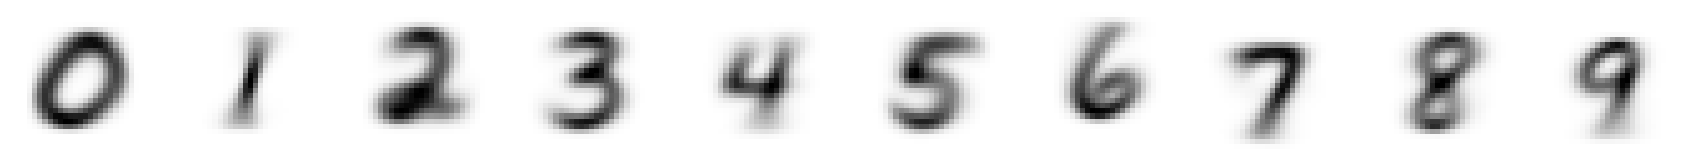

In [60]:
show_images(digit_means)

Read in validation set for testing accuracy

In [10]:
names_valid = [name + '_valid' for name in names]

assert len(names_valid) == len(digits)

for name, digit in zip(names_valid, digits):
    globals()[name] = img_files_to_tensor(path, 'testing', digit)

In [81]:
ones_valid.size()

torch.Size([1135, 28, 28])

Use loss function (rmse) to measure 'distance' from target image to average images.  Do this within a tensor (by averaging over the last 2 dimensions, i.e. the 28x28 images) to take advantage of broadcasting.

In [84]:
def rmse_loss(target, actual): return ((target - actual)**2).mean((-1, -2)).sqrt()

Use broadcasting to calculate distances for every image against every average digit in the validation set

In [85]:
rmse_loss(threes_valid, digit_means[3])

tensor([0.2117, 0.2256, 0.2331,  ..., 0.2060, 0.2326, 0.2256])

Nested list comprehension - loop through each digit (`valid_set`), and for each one compare to all digit means (`digit`).

In [91]:
digit_preds_all = [torch.stack([rmse_loss(globals()[valid_set], digit) for digit in digit_means]) for valid_set in names_valid]

Returns a 10 element (each digit) tensor that compares 10 digit means x n images:

In [92]:
[i.size() for i in digit_preds_all]

[torch.Size([10, 980]),
 torch.Size([10, 1135]),
 torch.Size([10, 1032]),
 torch.Size([10, 1010]),
 torch.Size([10, 982]),
 torch.Size([10, 892]),
 torch.Size([10, 958]),
 torch.Size([10, 1028]),
 torch.Size([10, 974]),
 torch.Size([10, 1009])]

Calculate the prediction by taking the minimum loss across the digit means for each image in the validation set.  Note that (conveniently) the index of the minimum is equal to the digit predicted.

In [95]:
digit_preds = [i.min(0).indices for i in digit_preds_all]

In [97]:
[i.size() for i in digit_preds]

[torch.Size([980]),
 torch.Size([1135]),
 torch.Size([1032]),
 torch.Size([1010]),
 torch.Size([982]),
 torch.Size([892]),
 torch.Size([958]),
 torch.Size([1028]),
 torch.Size([974]),
 torch.Size([1009])]

Accuracy for each digit:

In [110]:
digit_acc = [(digit, sum(digit_preds[digit] == digit).item() / len(digit_preds[digit])) for digit in range(10)]
digit_acc

[(0, 0.8959183673469387),
 (1, 0.9621145374449339),
 (2, 0.7567829457364341),
 (3, 0.805940594059406),
 (4, 0.8258655804480651),
 (5, 0.6860986547085202),
 (6, 0.8632567849686847),
 (7, 0.8326848249027238),
 (8, 0.7371663244353183),
 (9, 0.8067393458870169)]

Overall accuracy:

In [114]:
n_correct = sum([sum(digit_preds[digit] == digit).item() for digit in range(10)])
n_total = sum([len(digit_preds[digit]) for digit in range(10)])
n_correct / n_total

0.8203

# Trained models

## Manual implementation - linear learner

Use gradient descent to create a 'learner'.

1. Initialize weights
2. Make predictions
3. Calculate loss
4. Calculate gradient in loss
5. Update weights
6. Report loss and metrics
7. Repeat 2-6 for some number of steps
8. End

In [98]:
train_x = torch.cat([globals()[name] for name in names]).view(-1, 28*28)

flatten nested list: `[item for sublist in list for item in sublist]`

In [99]:
train_labels = [dig for digs in [[digit] * globals()[name].size(0) for digit, name in zip(digits, names)] for dig in digs]
train_y = tensor(pd.get_dummies(train_labels)).float()

In [100]:
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 10]))

In [101]:
valid_x = torch.cat([globals()[name] for name in names_valid]).view(-1, 28*28)

In [102]:
valid_labels = [dig for digs in [[digit] * globals()[name].size(0) for digit, name in zip(digits, names_valid)] for dig in digs]
valid_y = tensor(pd.get_dummies(valid_labels)).float()

In [103]:
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 10]))

1.  Initialize weights and bias 

Weights should return an N by C matrix when multiplied with preds, where N is the number of observations and C is the number of classes

In [138]:
weights = torch.randn(train_x.shape[1], 10).requires_grad_()
bias = torch.randn(10).requires_grad_()

In [139]:
weights.shape

torch.Size([784, 10])

2. Make predictions

In [140]:
preds = train_x @ weights + bias

In [141]:
preds.shape

torch.Size([60000, 10])

3. Calculate loss

Cross entropy:

In [146]:
loss = (-preds * train_y + preds.exp().sum(0).log()).mean()

4. Calculate loss gradient

In [147]:
loss.backward()

5. Update weights

Define learning rate

In [148]:
lr = 1e-5

Update weights

In [149]:
weights.data -= weights.grad * lr
bias.data -= bias.grad * lr

Zero gradients for next iteration

In [150]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

6. Report loss and metrics

In [151]:
loss

tensor(31.5764, grad_fn=<MeanBackward0>)

In [158]:
((valid_x @ weights + bias).argmax(1) == valid_y.argmax(1)).float().mean()

tensor(0.0924)

7. Iterate

In [177]:
loss_fn = torch.nn.CrossEntropyLoss()
out = loss_fn()

tensor([0., 0., 0.,  ..., 9., 9., 9.])

In [193]:
weights = torch.randn(train_x.shape[1], 10).requires_grad_()
bias = torch.randn(10).requires_grad_()
lr = 2.5
epochs = 500
print_interval = epochs / 20
loss_fn = torch.nn.CrossEntropyLoss()
    
for i in range(epochs + 1):
    # make predictions
    preds = train_x @ weights + bias
    # calculate loss
    loss = loss_fn(preds, tensor([float(lab) for lab in train_labels], dtype = torch.long))
    # loss = (-preds.sigmoid() * train_y + preds.sigmoid().sum(0)).mean()
    # loss = (-preds.sigmoid() * train_y).mean()
    # calculate gradients
    loss.backward()
    # update weights
    weights.data -= weights.grad * lr
    bias.data -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
    # calculate loss and accuracy on validation set
    valid_preds = valid_x @ weights + bias
    valid_loss = loss_fn(valid_preds, tensor([float(lab) for lab in valid_labels], dtype = torch.long))
    # valid_loss = (-valid_preds.sigmoid() * valid_y + valid_preds.sigmoid().sum(0)).mean()
    # valid_loss = (-valid_preds.sigmoid() * valid_y).mean()
    valid_acc = (valid_preds.argmax(1) == valid_y.argmax(1)).float().mean()
    # print output
    if i % print_interval == 0:
        print(
            "epoch ", i, 
            ", train loss = ", round(loss.item(), 3), 
            ", valid loss = ", round(valid_loss.item(), 3), 
            ", accuracy = ", round(valid_acc.item(), 3)
        )

epoch  0 , train loss =  11.794 , valid loss =  9.421 , accuracy =  0.29
epoch  25 , train loss =  1.264 , valid loss =  1.183 , accuracy =  0.778
epoch  50 , train loss =  0.925 , valid loss =  0.866 , accuracy =  0.829
epoch  75 , train loss =  0.78 , valid loss =  0.737 , accuracy =  0.846
epoch  100 , train loss =  0.698 , valid loss =  0.665 , accuracy =  0.859
epoch  125 , train loss =  0.642 , valid loss =  0.615 , accuracy =  0.865
epoch  150 , train loss =  0.601 , valid loss =  0.579 , accuracy =  0.869
epoch  175 , train loss =  0.57 , valid loss =  0.552 , accuracy =  0.873
epoch  200 , train loss =  0.547 , valid loss =  0.532 , accuracy =  0.877
epoch  225 , train loss =  0.531 , valid loss =  0.52 , accuracy =  0.876
epoch  250 , train loss =  0.512 , valid loss =  0.503 , accuracy =  0.883
epoch  275 , train loss =  0.495 , valid loss =  0.489 , accuracy =  0.883
epoch  300 , train loss =  0.484 , valid loss =  0.478 , accuracy =  0.887
epoch  325 , train loss =  0.473 

So by taking advantage of gradient descent, can improve classifier accuracy by ~8%.

## Linear learner - pytorch implementation

In [200]:
linear1 = torch.nn.Linear(28*28, 10)
opt = torch.optim.SGD(linear1.parameters(), lr = 1.5)
loss_fn = loss_fn = torch.nn.CrossEntropyLoss()

epochs = 200
print_interval = epochs / 20
    
for i in range(epochs + 1):
    opt.zero_grad()
    preds = linear1(train_x)
    loss = loss_fn(preds, tensor([float(lab) for lab in train_labels], dtype = torch.long))
    loss.backward()
    opt.step()
    # calculate loss and accuracy on validation set
    valid_preds = linear1(valid_x)
    valid_loss = loss_fn(valid_preds, tensor([float(lab) for lab in valid_labels], dtype = torch.long))
    valid_acc = (valid_preds.argmax(1) == valid_y.argmax(1)).float().mean()
    # print output
    if i % print_interval == 0:
        print(
            "epoch ", i, 
            ", train loss = ", round(loss.item(), 3), 
            ", valid loss = ", round(valid_loss.item(), 3), 
            ", accuracy = ", round(valid_acc.item(), 3)
        )

epoch  0 , train loss =  2.325 , valid loss =  1.55 , accuracy =  0.489
epoch  10 , train loss =  1.52 , valid loss =  0.893 , accuracy =  0.759
epoch  20 , train loss =  0.835 , valid loss =  0.869 , accuracy =  0.744
epoch  30 , train loss =  0.475 , valid loss =  0.438 , accuracy =  0.869
epoch  40 , train loss =  0.387 , valid loss =  0.366 , accuracy =  0.893
epoch  50 , train loss =  0.38 , valid loss =  0.366 , accuracy =  0.893
epoch  60 , train loss =  0.468 , valid loss =  0.448 , accuracy =  0.862
epoch  70 , train loss =  0.412 , valid loss =  0.389 , accuracy =  0.887
epoch  80 , train loss =  0.341 , valid loss =  0.325 , accuracy =  0.907
epoch  90 , train loss =  0.33 , valid loss =  0.317 , accuracy =  0.91
epoch  100 , train loss =  0.328 , valid loss =  0.316 , accuracy =  0.911
epoch  110 , train loss =  0.342 , valid loss =  0.334 , accuracy =  0.904
epoch  120 , train loss =  0.425 , valid loss =  0.402 , accuracy =  0.878
epoch  130 , train loss =  0.335 , valid 

Torch implementation of SGD - less code, and 2% increase in accuracy with less training time.

## Fastai linear learner

In [207]:
train_dset = list(zip(train_x, tensor([float(lab) for lab in train_labels], dtype = torch.long)))
valid_dset = list(zip(valid_x, tensor([float(lab) for lab in valid_labels], dtype = torch.long)))

In [220]:
bs = 10000
train_dl = DataLoader(train_dset, batch_size = bs)
valid_dl = DataLoader(valid_dset, batch_size = bs)
dls = DataLoaders(train_dl, valid_dl)

In [234]:
linear_learner = Learner(
    dls,
    nn.Linear(28*28, 10),
    loss_fn,
    opt_func = SGD,
    metrics = accuracy
)

linear_learner.fit(75, lr = 0.5)

Fastai is less code still.

## Adding nonlinearity

In [247]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)
opt = torch.optim.SGD(simple_net.parameters(), lr = 0.4)
loss_fn = loss_fn = torch.nn.CrossEntropyLoss()

epochs = 400
print_interval = epochs / 20
    
for i in range(epochs + 1):
    opt.zero_grad()
    preds = simple_net(train_x)
    loss = loss_fn(preds, tensor([float(lab) for lab in train_labels], dtype = torch.long))
    loss.backward()
    opt.step()
    # calculate loss and accuracy on validation set
    valid_preds = simple_net(valid_x)
    valid_loss = loss_fn(valid_preds, tensor([float(lab) for lab in valid_labels], dtype = torch.long))
    valid_acc = (valid_preds.argmax(1) == valid_y.argmax(1)).float().mean()
    # print output
    if i % print_interval == 0:
        print(
            "epoch ", i, 
            ", train loss = ", round(loss.item(), 3), 
            ", valid loss = ", round(valid_loss.item(), 3), 
            ", accuracy = ", round(valid_acc.item(), 3)
        )

epoch  0 , train loss =  2.329 , valid loss =  2.273 , accuracy =  0.113
epoch  20 , train loss =  0.758 , valid loss =  0.708 , accuracy =  0.842
epoch  40 , train loss =  0.522 , valid loss =  0.504 , accuracy =  0.842
epoch  60 , train loss =  0.419 , valid loss =  0.397 , accuracy =  0.888
epoch  80 , train loss =  0.374 , valid loss =  0.356 , accuracy =  0.899
epoch  100 , train loss =  0.346 , valid loss =  0.33 , accuracy =  0.908
epoch  120 , train loss =  0.328 , valid loss =  0.314 , accuracy =  0.912
epoch  140 , train loss =  0.314 , valid loss =  0.301 , accuracy =  0.915
epoch  160 , train loss =  0.303 , valid loss =  0.291 , accuracy =  0.918
epoch  180 , train loss =  0.293 , valid loss =  0.283 , accuracy =  0.921
epoch  200 , train loss =  0.285 , valid loss =  0.275 , accuracy =  0.923
epoch  220 , train loss =  0.277 , valid loss =  0.269 , accuracy =  0.925
epoch  240 , train loss =  0.27 , valid loss =  0.262 , accuracy =  0.927
epoch  260 , train loss =  0.263 

In [249]:
simple_net_2 = nn.Sequential(
    nn.Linear(28*28, 90),
    nn.ReLU(),
    nn.Linear(90, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)
opt = torch.optim.SGD(simple_net_2.parameters(), lr = 0.4)
loss_fn = loss_fn = torch.nn.CrossEntropyLoss()

epochs = 400
print_interval = epochs / 20
    
for i in range(epochs + 1):
    opt.zero_grad()
    preds = simple_net_2(train_x)
    loss = loss_fn(preds, tensor([float(lab) for lab in train_labels], dtype = torch.long))
    loss.backward()
    opt.step()
    # calculate loss and accuracy on validation set
    valid_preds = simple_net_2(valid_x)
    valid_loss = loss_fn(valid_preds, tensor([float(lab) for lab in valid_labels], dtype = torch.long))
    valid_acc = (valid_preds.argmax(1) == valid_y.argmax(1)).float().mean()
    # print output
    if i % print_interval == 0:
        print(
            "epoch ", i, 
            ", train loss = ", round(loss.item(), 3), 
            ", valid loss = ", round(valid_loss.item(), 3), 
            ", accuracy = ", round(valid_acc.item(), 3)
        )

epoch  0 , train loss =  2.309 , valid loss =  2.295 , accuracy =  0.126
epoch  20 , train loss =  3.218 , valid loss =  2.187 , accuracy =  0.34
epoch  40 , train loss =  0.778 , valid loss =  0.772 , accuracy =  0.719
epoch  60 , train loss =  0.502 , valid loss =  0.465 , accuracy =  0.862
epoch  80 , train loss =  0.402 , valid loss =  0.396 , accuracy =  0.881
epoch  100 , train loss =  0.335 , valid loss =  0.32 , accuracy =  0.908
epoch  120 , train loss =  0.42 , valid loss =  0.405 , accuracy =  0.874
epoch  140 , train loss =  0.281 , valid loss =  0.269 , accuracy =  0.921
epoch  160 , train loss =  0.26 , valid loss =  0.25 , accuracy =  0.928
epoch  180 , train loss =  0.245 , valid loss =  0.237 , accuracy =  0.932
epoch  200 , train loss =  0.235 , valid loss =  0.229 , accuracy =  0.933
epoch  220 , train loss =  0.214 , valid loss =  0.208 , accuracy =  0.94
epoch  240 , train loss =  0.201 , valid loss =  0.196 , accuracy =  0.944
epoch  260 , train loss =  0.19 , val

## Pure fastai implementation

Includes convolution layers, pretrained weights, learning rate scheduling.

In [289]:
dls = ImageDataLoaders.from_folder(path, train = 'training', valid = 'testing')
learn = cnn_learner(dls, resnet18, metrics = accuracy)
learn.fit_one_cycle(3, 0.1)

In [290]:
learn.predict(PILImage.create((path/'training'/'3').ls()[1]))

('3',
 tensor(3),
 tensor([2.2551e-08, 3.5677e-07, 1.2874e-06, 9.9978e-01, 8.4241e-08, 1.4726e-05, 4.6505e-06, 4.8936e-07, 1.9576e-04, 9.7576e-08]))

In [291]:
learn.predict(PILImage.create((path/'training'/'6').ls()[1]))

('6',
 tensor(6),
 tensor([4.5297e-08, 3.7495e-14, 1.9387e-13, 2.4422e-11, 6.5141e-13, 3.3742e-09, 1.0000e+00, 3.4196e-13, 3.5451e-09, 2.2543e-13]))